In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_parquet("/content/merged_stock_tweets_yfinance.parquet")

# Target
y = df["emotion"]

# Features
X = df.drop(columns=["emotion"])

# Time-aware split (NO stratify, NO shuffle)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    shuffle=False
)

print("Train distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest distribution:")
print(y_test.value_counts(normalize=True))


Train distribution:
emotion
Neutral     0.428838
Happy       0.310856
Fear        0.110483
Surprise    0.064605
Disgust     0.051885
Sad         0.020239
Anger       0.013094
Name: proportion, dtype: float64

Test distribution:
emotion
Neutral     0.433967
Happy       0.388505
Disgust     0.049623
Fear        0.043734
Surprise    0.041771
Sad         0.026303
Anger       0.016096
Name: proportion, dtype: float64


In [2]:
# Recombine training data
df_train = X_train.copy()
df_train["emotion"] = y_train

In [3]:
# Class imbalance BEFORE
before_counts = df_train["Stock Name"].value_counts()
min_count = before_counts.min()

# Downsampling
df_train_balanced = (
    df_train
    .groupby("Stock Name", group_keys=False)
    .apply(lambda x: x.sample(min_count, random_state=42))
)

# Class imbalance AFTER
after_counts = df_train_balanced["Stock Name"].value_counts()

print("\nBefore balancing:")
print(before_counts)

print("\nAfter balancing:")
print(after_counts)


Before balancing:
Stock Name
TSLA    30028
AAPL     4131
MSFT     3340
PG       3340
AMZN     3340
META     2317
AMD      1796
NFLX     1464
GOOG     1053
TSM       131
Name: count, dtype: Int64

After balancing:
Stock Name
AAPL    131
AMD     131
AMZN    131
GOOG    131
META    131
MSFT    131
NFLX    131
PG      131
TSLA    131
TSM     131
Name: count, dtype: Int64


/tmp/ipython-input-2562319139.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min_count, random_state=42))


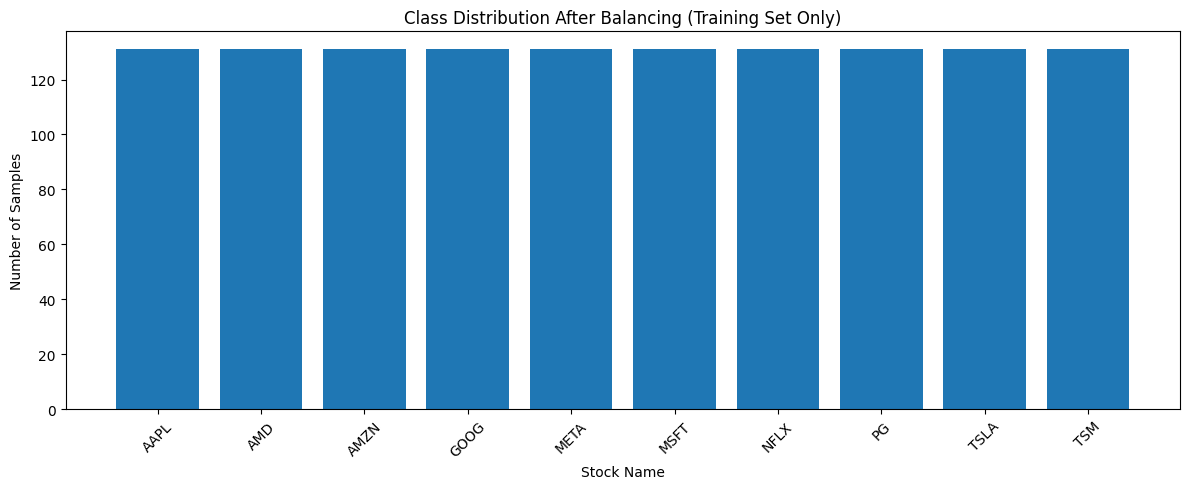

In [4]:
plt.figure(figsize=(12,5))
plt.bar(after_counts.index, after_counts.values)
plt.title("Class Distribution After Balancing (Training Set Only)")
plt.xlabel("Stock Name")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
# Final training data (balanced)
X_train_bal = df_train_balanced.drop(columns=["emotion"])
y_train_bal = df_train_balanced["emotion"]

# Validation/Test remain untouched
X_test_final = X_test
y_test_final = y_test

Do not run the next cell

In [7]:
import json

with open("Practicum_Final_1.ipynb", "r", encoding="utf-8") as f:
    nb = json.load(f)

nb["metadata"].pop("widgets", None)

with open("Practicum_Final_1.ipynb", "w", encoding="utf-8") as f:
    json.dump(nb, f, indent=1)

print("Widget metadata removed successfully")


Widget metadata removed successfully
